In [113]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import solve
from data import *




class MFModel(object):

    def __init__(self, rates_dict, test_rates_dict, num_users, num_items, hidden_dim, lr, gamma, epochs, optimizer, reg_u, reg_i):
        """ Params:
        1) ratings - rating matrix (as dict)
        2) hidden_dim  - number of latent dimensions (as integer)
        3) lr - learning rate (as float)
        4) gamma - regulaizer (as float)
        5) opechs - as int
        """

        self.ratings_dict = rates_dict
        self.test_ratings_dict = test_rates_dict
        self.num_users = num_users
        self.num_items = num_items
        self.K = hidden_dim
        self.optimizer = optimizer
        self.lr = lr
        self.gamma = gamma
        self.regulizer_items = reg_i
        self.regulizer_users = reg_u
        self.epochs = epochs
        self.scbd = []
        
    def print_hyper_params(self):
        print("latent dimention %d" % (self.K))
        print("learning rate %r" % (self.lr))
        print("lambda SGD %r" % (self.gamma))
        print("lambda ALS users %r" % (self.regulizer_users))
        print("lambda ALS items %r" % (self.regulizer_items))
        print("Epochs %d" % (self.epochs))

    def init(self, isize, ik, kind='normal'):
        if kind == 'normal':
            return np.random.normal(scale=1.0/ik, size=(isize, ik))
        elif kind == 'uniform':
            return np.random.uniform(-1.0/ik, 1.0/ik)


    def train_model(self):

        def reset(samples):
            np.random.shuffle(samples)

        self.samples = []
        # prepare the samples samples
        for u, items in self.ratings_dict.items():
            for i, r, _ in items:
                self.samples += [(u, i, r)]

        self.U = self.init(self.num_users, self.K, kind='normal')
        self.V = self.init(self.num_items, self.K, kind='normal')

        # Initialize the biases
        self.bu = np.zeros(self.num_users)
        self.bv = np.zeros(self.num_items)


        for epoch in range(self.epochs):
            reset(self.samples)
            if self.optimizer == 'sgd':
                self.LearnModelFromDataUsingSGD()
            elif self.optimizer == 'als':
                self.LearnModelFromDataUsingALS()
            train_rmse = self.RMSE(is_train=True)
            val_rmse = self.RMSE()
            print("[Epoch %d] : train RMSE = %.4f" % (epoch, train_rmse))
            if epoch % 5 == 0:
                print("[Epoch %d] : validation RMSE = %.4f" % (epoch, val_rmse))
            self.scbd.append((epoch, train_rmse, val_rmse))


    def LearnModelFromDataUsingSGD (self):
        """
        Performs one iteration on one of the User/Items matrices
        """    
        for u, v, rate in self.samples:
            prediction = self.bu[u] + self.bv[v] + self.U[u, :].dot(self.V[v, :].T)
            err = (rate - prediction)

            # update biases
            self.bu[u] += self.lr * (err - self.gamma * self.bu[u])
            self.bv[v] += self.lr * (err - self.gamma * self.bv[v])

            # update user item metrices
            self.U[u, :] += self.lr * (err * self.V[v, :] - self.gamma * self.U[u, :])
            self.V[v, :] += self.lr * (err * self.U[u, :] - self.gamma * self.V[v, :])
            
    
    def LearnModelFromDataUsingALS(self):
        """
        Performs one iteration on one of the User/Items matrices
        """             
        rate_mat = np.zeros((self.num_users, self.num_items))
        for user, item in self.ratings_dict.items():
            for movie, rate, _ in item:
                rate_mat[user][movie] = rate
    
            
        # Users update
        lambda_u = np.eye(self.K) * self.regulizer_users
        for u_idx, u_rate in enumerate(rate_mat):
            u_rate[u_rate != 0] = 1.0
            self.U[u_idx,:] = solve(np.dot(self.V.T, np.dot(np.diag(u_rate), self.V)) + lambda_u,
                                       np.dot(self.V.T, np.dot(np.diag(u_rate), rate_mat[u_idx,:].T))).T

            
        # Items update
        lambda_i = np.eye(self.K) * self.regulizer_items
        for i_idx, i_rate in enumerate(rate_mat.T):
            i_rate[i_rate != 0] = 1.0
            self.V[i_idx,:] = solve(np.dot(self.U.T, np.dot(np.diag(i_rate), self.U)) + lambda_i,
                                         np.dot(self.U.T, np.dot(np.diag(i_rate), rate_mat[:, i_idx])))



            
    def RMSE(self, is_train=False):
        mod_pred = self.bu[:,np.newaxis] + self.bv[np.newaxis:,] + self.U.dot(self.V.T)
        total_err = 0
        r_cnt = 0
        ratings_dict = self.ratings_dict if is_train else self.test_ratings_dict
        for u, items in ratings_dict.items():
            for i, r, _ in items:
                total_err += pow(r - mod_pred[u, i], 2)
                r_cnt += 1
        return np.sqrt(total_err / r_cnt)




In [108]:
# 1a - SGD
model = MFModel(X_train, X_test, users, items, hidden_dim=40, lr=0.01, gamma=0.1, reg_u=0.1, reg_i=0.1, epochs=22, optimizer='sgd')
print("Starting training SGD...")
model.print_hyper_params()
model.train_model()

Starting training SGD...
latent dimention 40
learning rate 0.01
lambda SGD 0.1
lambda ALS users 0.1
lambda ALS items 0.1
Epochs 22
[Epoch 0] : train RMSE = 1.0481
[Epoch 0] : validation RMSE = 1.0967
[Epoch 1] : train RMSE = 0.9747
[Epoch 2] : train RMSE = 0.9505
[Epoch 3] : train RMSE = 0.9372
[Epoch 4] : train RMSE = 0.9301
[Epoch 5] : train RMSE = 0.9250
[Epoch 5] : validation RMSE = 0.9443
[Epoch 6] : train RMSE = 0.9184
[Epoch 7] : train RMSE = 0.9107
[Epoch 8] : train RMSE = 0.9026
[Epoch 9] : train RMSE = 0.8951
[Epoch 10] : train RMSE = 0.8885
[Epoch 10] : validation RMSE = 0.9132
[Epoch 11] : train RMSE = 0.8831
[Epoch 12] : train RMSE = 0.8783
[Epoch 13] : train RMSE = 0.8730
[Epoch 14] : train RMSE = 0.8686
[Epoch 15] : train RMSE = 0.8660
[Epoch 15] : validation RMSE = 0.8979
[Epoch 16] : train RMSE = 0.8630
[Epoch 17] : train RMSE = 0.8607
[Epoch 18] : train RMSE = 0.8581
[Epoch 19] : train RMSE = 0.8560
[Epoch 20] : train RMSE = 0.8543
[Epoch 20] : validation RMSE = 0.890

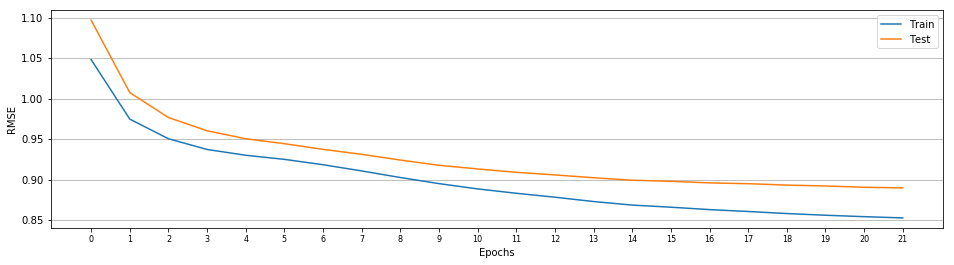

In [109]:
train_rmse = [t for e, t, v in model.scbd]
test_rmse = [v for e, t, v in model.scbd]
epochs = [e for e, t, v in model.scbd]
plt.figure(figsize=((16,4)))
plt.plot(epochs, train_rmse, label="Train")
plt.plot(epochs, test_rmse, label="Test")
plt.legend()
plt.xticks(epochs, fontsize=8)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.grid(axis="y")

In [114]:
# 1b - ALS
model = MFModel(X_train, X_test, users, items, hidden_dim=3, lr=0.001, gamma=0.1, reg_u=0.1, reg_i=0.1, epochs=21, optimizer='als')
print("Starting training ALS...")
model.print_hyper_params()
model.train_model()

Starting training ALS...
latent dimention 3
learning rate 0.001
lambda SGD 0.1
lambda ALS users 0.1
lambda ALS items 0.1
Epochs 21
[Epoch 0] : train RMSE = 3.6549
[Epoch 0] : validation RMSE = 3.5392
[Epoch 1] : train RMSE = 2.8577


KeyboardInterrupt: 

In [ ]:
train_rmse = [t for e, t, v in model.scbd]
test_rmse = [v for e, t, v in model.scbd]
epochs = [e for e, t, v in model.scbd]
plt.figure(figsize=((16,4)))
plt.plot(epochs, train_rmse)
plt.plot(epochs, test_rmse)
plt.xticks(epochs, fontsize=8)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.grid(axis="y")